In [76]:
import matplotlib.pyplot as plt
import os
import imageio.v3 as iio
import numpy as np
import pandas as pd
import json
import skimage.morphology as morph
from skimage.morphology import medial_axis

In [68]:
CONFIG = json.load(open("../../config/phases_config.json"))

In [30]:
ROOT_DIR = os.path.abspath("/Users/gimli/cvr/data/microscopy/sw-output-tmp")
SAMPLE = "E01_101"

In [31]:
crack_mask = iio.imread(os.path.join(ROOT_DIR, "crack_mask", SAMPLE, f"{SAMPLE}-crack-mask.png"))
phase_map = iio.imread(os.path.join(ROOT_DIR, "phase_map", SAMPLE, f"{SAMPLE}-[user]phase_map.png"))
meta = pd.read_csv(os.path.join(ROOT_DIR, "results", SAMPLE, f"{SAMPLE}-skeleton-neighbors.csv"))

### Crop definition

In [111]:
shift = [300, 1350]
crop_size = 100
row = meta[(meta["crack skeleton coord X"] == 1425) & (meta["crack skeleton coord Y"] == 378)]
crack_crop = np.moveaxis(np.tile(crack_mask[shift[0]:shift[0] + crop_size, shift[1]:shift[1] + crop_size], (3, 1, 1)),
                         0, 2)
phase_crop = phase_map[shift[0]:shift[0] + crop_size, shift[1]:shift[1] + crop_size]
medial = morph.medial_axis(crack_crop[:, :, 0])
phase_crop[crack_crop != 0] = 0
phase_crop[medial != 0] = np.array([128, 128, 128])

In [83]:
row.columns

Index(['crack skeleton coord X', 'crack skeleton coord Y', 'crack ID',
       'branch ID', 'gradient X', 'gradient Y', 'left neighbor X',
       'left neighbor Y', 'right neighbor X', 'right neighbor Y',
       'left neighbor phase ID', 'right neighbor phase ID'],
      dtype='object')

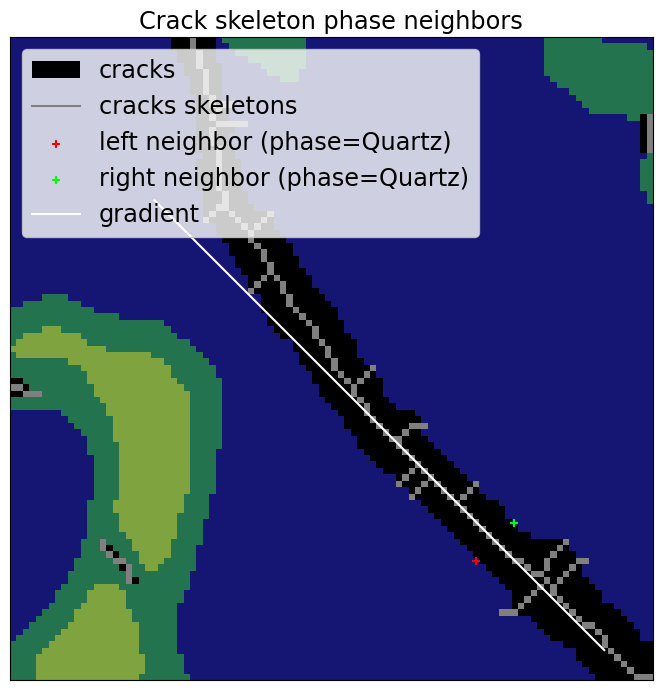

In [126]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

blend = 0.5
plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
lines = []
ax.imshow(phase_crop)
h1 = ax.scatter(row["left neighbor Y"] - shift[1],
           row["left neighbor X"] - shift[0],
           color="red",
           marker="+",
           label=f"left neighbor (phase={CONFIG['labels'][row['left neighbor phase ID'].to_numpy()[0].astype(int)]})")
h2 = ax.scatter(row["right neighbor Y"] - shift[1],
           row["right neighbor X"] - shift[0],
           color="lime",
           marker="+",           
           label=f"right neighbor (phase={CONFIG['labels'][row['left neighbor phase ID'].to_numpy()[0].astype(int)]})")
h3 = ax.plot([row['gradient X'] * t + 75 for t in np.arange(-75, +25)],
        [row['gradient Y'] * t + 80 for t in np.arange(-78, +22)], color="white", label="gradient")
h5 = Patch(facecolor="black", label="cracks", )
h4 = Line2D([80], [75], color="gray", label="cracks skeletons")
ax.set_xticks([])
ax.set_yticks([])
plt.legend(handles=[h5, h4, h1, h2, h3[0]], loc="upper left", fontsize="xx-large")
plt.title("Crack skeleton phase neighbors", fontsize="xx-large")
plt.tight_layout()
plt.savefig(os.path.join(ROOT_DIR, "figures", SAMPLE, f"{SAMPLE}-neighbors.png"), transparent=True)
plt.show()

In [102]:
h3